# Which community assembly mechanisms structure the  amphibian microbiome?

In this analysis, we analyze the effects of Bd on the processes structuring the *R. muscosa* microbiome in field.  In particular, we explore how Bd acting as a disturbance can change the dominant processes structuring the amphibian microbiome.  We are examining three major community assembly processes (Velland 2010, 2016).

1. Drift
2. Dispersal
3. Selection

We are not including speciation/diversification, the fourth major process, in this study.

We are examining four lakes that have a range of Bd loads and over 10 frogs sampled. Could possible include Kuna in the analysis as well. 

In [1]:
import pandas as pd
import pystan
import numpy as np
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
import scipy.stats as stats
import os
home = os.getcwd()
os.chdir("/Users/mqwilber/Dropbox/Documents/Stats/Stan/PSIS/py/")
import psis
os.chdir(home)
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = "white"

In [2]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [2]:
field = pd.read_csv("../data/formatted/OTUdata_formatted.csv")
otu_tax = pd.read_csv("../data/archival/SierraOTUTaxonomy.csv").set_index("OTU")


field.columns = ["_".join(c.split(" ")) for c in field.columns]
field = field.assign(Date_Collected = lambda x: pd.to_datetime(x.Date_Collected))

## DISCARD 11517 AS IT WAS STORED DIFFERENTLY
field = field[field.Lake_ID != 11517]

## DROP EARLY MARMOT SITE TO AVOID CONFOUNDING BY SEASON
field = field[field.Date_Collected != pd.datetime(2010, 8, 8)]


/Users/mqwilber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
attributes = field[field.columns[:11]]
otus_field = field[field.columns[11:]]

In [34]:
# maplake = {72996: "Conness", 11516: "Dusy 1", 
#            11525: "Dusy 2",  72974: "Kuna", 
#            50183: "Marmot", 72425: "Mono", 
#            72808: "Unicorn"}

maplake = {72996: "YOSE 4", 11516: "SEKI 1", 
           11525: "SEKI 2",  72974: "YOSE 3", 
           50183: "SEKI 3", 72425: "YOSE 1", 
           72808: "YOSE 2"}

(field[field.sample_type == "swab"].groupby(['Site_Name', "Lake_ID", "Date_Collected"])
           .agg({'ZE1': np.nanmean, 'sample_type': len}))

ZE1  sample_type
Site_Name      Lake_ID Date_Collected                           
Conness        72996   2010-08-18       8584.075234           18
Dusy Basin     11516   2010-08-22          0.000000            8
                       2010-09-09         17.270603           10
               11525   2010-08-23      87206.689377            8
Kuna Basin     72974   2010-08-27       2180.656162            8
LeConte Canyon 10100   2010-09-04          0.000000            8
Marmot Lake    50183   2010-08-30      21804.264279           20
                       2010-09-14      49830.001597           10
Mono Pass      72425   2010-09-01      38695.955935            8
                       2010-09-16       5808.406505           18
Rambaud Basin  10196   2010-09-06          0.000000            8
Snowpole Lake  51058   2010-08-31          0.392929            8
Unicorn        72808   2010-08-29        355.682399            7
                       2010-09-13       2135.354564           18

In [29]:
# Lake IDs that don't have any BD.  
lake_ids = [51058, 10196, 10100]

In [5]:
# Lakes to include in analysis
lake_ids = [72996, 50183, 72425, 72808, 72974, 11525, 11516]
#lake_ids = [72996, 50183, 72425, 72808, 72974] # All Lakes that have a spread of Bd loads

In [17]:
# Extract data for Andrea
field[field.Lake_ID.isin(lake_ids)][['Group']].reset_index(drop=True).to_csv("../results/group_ids_for_andrea.csv")

## Load the different Bd models

In [5]:
#betabinom = pystan.StanModel("stan_code/neutral_beta_binomial.stan")
#pd.to_pickle(betabinom, "stan_code/neutral_beta_binomial.pkl")
betabinom = pd.read_pickle("stan_code/neutral_beta_binomial.pkl")

In [6]:
#betabinom_mean = pystan.StanModel("stan_code/neutral_beta_binomial_meaneffects.stan")
#pd.to_pickle(betabinom_mean, "stan_code/neutral_beta_binomial_meaneffects.pkl")
betabinom_mean = pd.read_pickle("stan_code/neutral_beta_binomial_meaneffects.pkl")

In [7]:
#betabinom_meanrand = pystan.StanModel("stan_code/neutral_beta_binomial_meanrandomeffects.stan")
#pd.to_pickle(betabinom_meanrand, "stan_code/neutral_beta_binomial_meanrandomeffects.pkl")
betabinom_meanrand = pd.read_pickle("stan_code/neutral_beta_binomial_meanrandomeffects.pkl")

In [8]:
#dirichlet_mean = pystan.StanModel("stan_code/neutral_dirichlet_multinomial_meaneffects.stan")
#pd.to_pickle(dirichlet_mean, "stan_code/neutral_dirichlet_multinomial_meaneffects.pkl")
dirichlet_mean = pd.read_pickle("stan_code/neutral_dirichlet_multinomial_meaneffects.pkl")

In [11]:
# Fitting all lakes simultaneously

site_dat = (field[(field.Lake_ID.isin(lake_ids)) & (field.sample_type == "swab")]
                 .reset_index(drop=True))

# Impute the missing SVLs as mean for subadults
mean_svl = site_dat[site_dat.Life_Stage == "subadult"].SVL.mean()
site_dat.loc[site_dat.SVL.isna(), "SVL"] = mean_svl

# Let's look across all OTUs
site_otus = site_dat.iloc[:, 11:]

metacomm_p = (site_otus.T / site_otus.sum(axis=1)).T.mean(axis=0).sort_values(ascending=False)
sorted_otus = site_otus[metacomm_p.index.values]

# Group on the most abundant OTUs in the metacommunity and other OTUs
num_otus = 19
samp_size = sorted_otus.shape[0]
Nts = sorted_otus.sum(axis=1).values
abund_otus = sorted_otus.iloc[:, :num_otus]
other_otus = sorted_otus.iloc[:, num_otus:].sum(axis=1)
abund_otus = abund_otus.assign(Other=other_otus)
abund = abund_otus.values
relative_otus = (abund_otus.values.T / abund_otus.sum(axis=1).values).T

meta_p_otus = np.append(metacomm_p.values[:num_otus], metacomm_p.values[num_otus:].sum())
site_dat.loc[:, "logZE_z"] = StandardScaler().fit_transform(np.log10(site_dat.ZE1 + 1)[:, np.newaxis])

# Set up design matrices
Xmat = dmatrix("scale(SVL) + logZE_z", data=site_dat, return_type="dataframe").values
Xmatlake = dmatrix("scale(SVL) + logZE_z + C(Lake_ID)", data=site_dat, return_type="dataframe").values
Xmatlake_int = dmatrix("scale(SVL) + logZE_z*C(Lake_ID)", data=site_dat, return_type="dataframe").values
XmatBd = dmatrix("logZE_z", data=site_dat, return_type="dataframe").values
Xmat2 = dmatrix("scale(SVL) + logZE_z + np.power(logZE_z, 2)", data=site_dat, return_type="dataframe").values
Xones = np.repeat(1, samp_size)[:, np.newaxis]
Xsvl = dmatrix("scale(SVL)", data=site_dat, return_type="dataframe").values
Xlake = dmatrix("C(Lake_ID)", data=site_dat, return_type="dataframe").values
Xsvllake = dmatrix("scale(SVL) + C(Lake_ID)", data=site_dat, return_type="dataframe").values
XlakeBd = dmatrix("C(Lake_ID) + logZE_z", data=site_dat, return_type="dataframe").values
XlakeBd_int = dmatrix("C(Lake_ID)*logZE_z", data=site_dat, return_type="dataframe").values
XlakeBd2 = dmatrix("C(Lake_ID) + logZE_z + np.power(logZE_z, 2)", data=site_dat, return_type="dataframe").values
XlakeBd2_int = dmatrix("C(Lake_ID)*logZE_z + C(Lake_ID)*np.power(logZE_z, 2)", data=site_dat, return_type="dataframe").values
XBd2 = dmatrix("logZE_z + np.power(logZE_z, 2)", data=site_dat, return_type="dataframe").values

# (model, Dispersal fixed effects, dispersal random effects, mean fixed effects)
model_Xs = {'base':   (betabinom_mean, Xones, Xones, Xones),
            'mean-lake': (betabinom_mean, Xones, Xones, Xlake),
            'mean-lake_I-svl': (betabinom_mean, Xsvl, Xones, Xlake),
            'mean-lake_I-svl-Bd': (betabinom_mean, Xmat, Xones, Xlake),
            'mean-lake_I-svl-Bd-lake': (betabinom_mean, Xmatlake, Xones, Xlake),
            'mean-lake_I-svl-Bd-lake-int': (betabinom_mean, Xmatlake_int, Xones, Xlake),
            'mean-lake_I-svl-lake_random': (betabinom_meanrand, Xsvllake, Xones, Xlake),
            'mean-lake_I-svl-Bd-lake-int_random': (betabinom_meanrand, Xmatlake_int, Xones, Xlake),
            'mean-lake_I-svl-Bd-lake-int_random-Bd': (betabinom_meanrand, Xmatlake_int, XmatBd, Xlake),
            'mean-lake_I-svl-Bd-lake_random': (betabinom_meanrand, Xmatlake, Xones, Xlake),
            'mean-lake_I-svl-Bd-lake_random-Bd': (betabinom_meanrand, Xmatlake, XmatBd, Xlake),
            'mean-lake_I-svl-Bd-lake-int_random-Bd': (betabinom_meanrand, Xmatlake_int, XmatBd, Xlake),
            'mean-lake-Bd2-int_I-svl-Bd-lake-int_random-Bd': (betabinom_meanrand, Xmatlake_int, XmatBd, XlakeBd2_int),
            'mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd': (betabinom_meanrand, Xmatlake, XmatBd, XlakeBd2_int),
            'mean-lake-Bd-int_I-svl-Bd-lake_random-Bd': (betabinom_meanrand, Xmatlake, XmatBd, XlakeBd_int),
            'mean-lake-Bd2-int_I-svl-Bd-lake_random': (betabinom_meanrand, Xmatlake, Xones, XlakeBd2_int),
            'mean-lake-Bd2-int_I-svl-lake_random': (betabinom_meanrand, Xsvllake, Xones, XlakeBd2_int),
            'mean-lake-Bd2-int_I-svl_random': (betabinom_meanrand, Xsvl, Xones, XlakeBd2_int),
            'mean-lake-Bd2-int_I-svl-Bd_random': (betabinom_meanrand, Xmat, Xones, XlakeBd2_int),
            'mean-lake-Bd2-int_I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, XlakeBd2_int),
            'mean-lake-Bd2-int': (betabinom_mean, Xones, Xones, XlakeBd2_int),
            'I-svl-Bd-lake-int_random-Bd': (betabinom_meanrand, Xmatlake_int, XmatBd, Xones),
            'I-svl-Bd-lake_random-Bd': (betabinom_meanrand, Xmatlake, XmatBd, Xones),
            'I-svl-Bd_random-Bd': (betabinom_meanrand, Xmat, XmatBd, Xones),
            'mean-lake-Bd2-int_I-svl-Bd_dirichlet': (dirichlet_mean, Xmat, Xones, XlakeBd2_int),
            'mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet': (dirichlet_mean, Xmatlake, Xones, XlakeBd2_int)}


# Dirichlet models for later fitting
#             'base_dirichlet' : (dirichlet_mean, Xones, Xones, Xones),
#             'mean-lake_dirichlet': (dirichlet_mean, Xones, Xones, Xlake),
#             'mean-lake_I-svl_dirichlet': (dirichlet_mean, Xsvl, Xones, Xlake),
#             'mean-lake_I-svl-Bd_dirichlet': (dirichlet_mean, Xmat, Xones, Xlake),
#             'mean-lake_I-svl-Bd2_dirichlet': (dirichlet_mean, Xmat2, Xones, Xlake),
#             'mean-lake-Bd_I-svl-Bd2_dirichlet': (dirichlet_mean, Xmat2, Xones, XlakeBd),
#             'mean-lake-Bd2_I-svl-Bd2_dirichlet': (dirichlet_mean, Xmat2, Xones, XlakeBd2),
#             'mean-lake-Bd2_I-svl-Bd_dirichlet': (dirichlet_mean, Xmat, Xones, XlakeBd2),
#             'mean-lake-Bd2-int_I-svl-Bd_dirichlet': (dirichlet_mean, Xmat, Xones, XlakeBd2_int),
#             'mean-lake-Bd2_I-svl_dirichlet': (dirichlet_mean, Xsvl, Xones, XlakeBd2)}

In [19]:
mnames = ['mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd', 
          'mean-lake-Bd2-int_I-svl-lake_random',
          'mean-lake_I-svl-lake_random']

In [49]:
# Models for Lakes with no Bd
noBdmodels = ['base', "mean-lake", 'mean-lake_I-svl', 'mean-lake_I-svl-lake_random']

In [50]:
fits = {}

#['mean-lake-Bd2-int_I-svl-Bd_random', 'mean-lake-Bd2-int_I-svl-lake_random',  'mean-lake-Bd2-int_I-svl_random']
mnames = noBdmodels

for model in mnames:#model_Xs.keys():

    print("Working on {0}".format(model))
    tmod, X, Z, W = model_Xs[model]

    if W is None:
        standata = dict(S = num_otus + 1, N = samp_size, P=X.shape[1], G=Z.shape[1],
                    abund=abund, meta_p=meta_p_otus, X=X, Z=Z, Nt=Nts)
    else:
        standata = dict(S = num_otus + 1, N = samp_size, P=X.shape[1], G=Z.shape[1],
                    abund=abund, meta_p=meta_p_otus, X=X, Z=Z, W=W, K=W.shape[1], Nt=Nts)
    
    # TODO: Refit with 3 chains
    fit_field = tmod.sampling(data=standata, iter=3000, warmup=1500, chains=3)
    irhat = fit_field.summary()['summary_colnames']
    irhat = irhat.index("Rhat")
    irhat = fit_field.summary()["summary"][:, irhat]
    print(fit_field.summary()['summary_rownames'][np.isnan(irhat)])
    print(fit_field.summary()['summary_rownames'][irhat > 1.1])
    
    # Save the model fits
    stanfit = fit_field.extract()
    to_pkl = (stanfit, standata, X, Z, W, site_dat.ZE1.values)
    pd.to_pickle(to_pkl, "../results/model_fits/{0}-numOTU{1}_noBdlakes.pkl".format(model, num_otus))
    fits[model] = fit_field

Working on base


['abund_OTU[1]' 'abund_OTU[2]']
[]
Working on mean-lake


['abund_OTU[1]' 'abund_OTU[2]']
[]
Working on mean-lake_I-svl


['abund_OTU[1]' 'abund_OTU[2]']
[]
Working on mean-lake_I-svl-lake_random


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


['abund_OTU[1]' 'abund_OTU[2]']
[]


In [52]:
num_otus = 19
models = list(model_Xs.keys())

loos = {}
for model in mnames: #models:
    
    try:
        stanfit = pd.read_pickle("../results/model_fits/{0}-numOTU{1}_noBdlakes.pkl".format(model, num_otus))[0]
        loo_res = psis.psisloo(stanfit['log_lik'])
        print(model, np.sum(loo_res[-1] > 0.7)) # Check PSIS criteria
        loos[model] = [-2*loo_res[0]]
    except FileNotFoundError:
        pass

# Build WAIC/LOO-IC/DIC table
model_fits = pd.DataFrame(loos).T.rename(columns={0:"LOO"})
model_fits = model_fits.round(decimals=2)
delta_table = model_fits - model_fits.min(axis=0)
delta_table = delta_table.assign(w=lambda x: np.exp(-0.5*x.LOO) / np.sum(np.exp(-0.5*x.LOO)))
#print(lake)
print(delta_table.round(3))

base 0
mean-lake 1
mean-lake_I-svl 1
mean-lake_I-svl-lake_random 5
                                LOO    w
base                         150.20  0.0
mean-lake                    136.89  0.0
mean-lake_I-svl              130.74  0.0
mean-lake_I-svl-lake_random    0.00  1.0


In [117]:
dmatrix("scale(SVL) + C(Lake_ID)", data=site_dat, return_type="dataframe").columns

Index(['Intercept', 'C(Lake_ID)[T.72425]', 'C(Lake_ID)[T.72808]',
       'C(Lake_ID)[T.72974]', 'C(Lake_ID)[T.72996]', 'scale(SVL)'],
      dtype='object')

In [53]:
nms = dmatrix("scale(SVL) + C(Lake_ID)", data=site_dat, return_type="dataframe").columns
stanfit = pd.read_pickle("../results/model_fits/mean-lake_I-svl-lake_random-numOTU19_noBdlakes.pkl")[0]
pd.DataFrame(stats.scoreatpercentile(stanfit['beta'], (2.5, 50, 97.5), axis=0), columns=nms)

,Intercept,C(Lake_ID)[T.10196],C(Lake_ID)[T.51058],scale(SVL)
0,0.449607,-0.183011,-0.405164,-0.316782
1,1.527237,0.299637,0.104418,-0.162428
2,2.562371,0.796919,0.600002,-0.010768


In [26]:
stanfit['beta'].std(axis=0)

array([0.35012206, 0.34771746, 0.2421704 , 0.21516725, 0.18729279,
       0.28040559, 0.20975485, 0.04925843, 0.12889625])

**Log-Linear Effect of Bd on recruitment and SVL on recruitment**

In [47]:
cols = dmatrix("scale(SVL) + logZE_z + C(Lake_ID)", data=site_dat, return_type="dataframe").columns
cols
np.sort(site_dat.Lake_ID.unique())

array([11516, 11525, 50183, 72425, 72808, 72974, 72996])

here
here
here
here
here
here
here
here
here
here
here
here
here
here


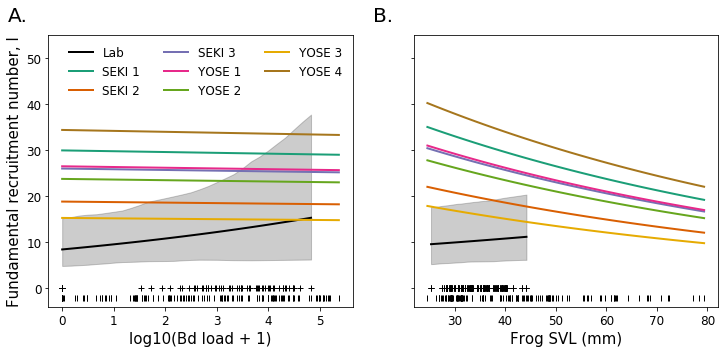

In [35]:
labdata = pd.read_csv("../results/formatted_lab_data.csv")
site_dat.loc[:, "svl"] = site_dat.SVL

num_otus = 19
colors = sns.color_palette()
models = ["mean-treatment-Bd2_I-svl-Bd_random-Bd", "mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"]
suffix = ["_lab", ""]
labels = ["Lab", "Field"]
letters = ["A.", "B."]
datasets = [labdata, site_dat]
lf_colors = [colors[0], colors[3]]
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=True)
axes = axes.ravel()
sorted_lake_ids  = np.sort(lake_ids)
colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]

dmat_inds_list = [[0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6]]
svl_bd_ind = [7, 8]

for i, ax in enumerate(axes):
    
    for m, model in enumerate(models):

        for d, dmat_inds in enumerate(dmat_inds_list):

            data = datasets[m]

            stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}{2}.pkl".format(model, num_otus, suffix[m]))

            dt = stats.scoreatpercentile(stanfit['beta'], (25, 50, 75), axis=0)
            if m == 0: # Lab data
                dt_df = pd.DataFrame(dt, columns=["Int.", "svl", "Bd"], index=["2.5%", "50%", "97.5%"])
            else:

                # Compute intercept estimate for specific lakes
                int_est = stats.scoreatpercentile(stanfit['beta'][:, dmat_inds].sum(axis=1), (25, 50, 75))[:, np.newaxis]
                dt_up = np.hstack([int_est, dt[:, svl_bd_ind]])
                dt_df = pd.DataFrame(dt_up, columns=["Int.", "svl", "Bd"], index=["2.5%", "50%", "97.5%"])
                X = X[:, [0] + svl_bd_ind]

            logbd = np.log10(bd_load + 1)
            pred_bd = np.linspace(np.min(logbd), np.max(logbd), num=30)
            pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)

            svl_z = X[:, 1]
            pred_svl = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), num=30)

            med_beta = dt_df.values[1, :][:, np.newaxis]

            if i == 0: # Load effect
                svl_val = (40 - data.svl.mean()) / (data.svl.std())
                Xpred = dmatrix("svl + x", data={"x": pred_bd_z, "svl": np.repeat(svl_val, len(pred_bd_z))})
                predx = pred_bd
                obsx = logbd
            else: # SVL effect
                bd_val = (2 - np.mean(logbd)) / np.std(logbd)
                Xpred = dmatrix("svl + x", data={"x": np.repeat(bd_val, len(pred_bd_z)), "svl": pred_svl})
                predx = pred_svl*data.svl.std() + data.svl.mean()
                obsx = X[:, 1]*data.svl.std() + data.svl.mean()

            predy = np.exp(np.dot(Xpred, med_beta)).ravel()
            
            if i == 0:
                ax.set_xlabel("log10(Bd load + 1)", size=15)
                ax.set_ylabel("Fundamental recruitment number, I", size=15)
            else:
                ax.set_xlabel("Frog SVL (mm)", size=15)

            ax.tick_params(labelsize=12)

            tpreds = []
            for temp in range(500):
                randi = np.random.randint(0, stanfit['beta'].shape[0])
                if m == 0:
                    tbeta = stanfit['beta'][randi, :]
                else:
                    int_est = stanfit['beta'][:, dmat_inds].sum(axis=1)[randi]
                    tbeta = np.hstack([int_est, stanfit['beta'][randi, svl_bd_ind]])

                ty = np.exp(np.dot(Xpred, tbeta)).ravel()
                tpreds.append(ty)
                #ax.plot(predx, ty, color="black", alpha=0.3, zorder=-1)
            ul = stats.scoreatpercentile(np.array(tpreds), (2.5, 97.5), axis=0)
            
            if m == 0:
                if d == 0:
                    ax.plot(predx, predy, lw=2, color="black", label=labels[m])
                    ax.plot(obsx, np.repeat(0 - 2*m, len(obsx)), ls="", marker="+", color="black")
                    ax.fill_between(predx, ul[0, :], ul[1, :], alpha=0.2, color="black")
            else:
                ax.plot(predx, predy, lw=2, color=colors[d], label="{0}".format(maplake[sorted_lake_ids[d]]))
                
                if d == 0:
                    ax.plot(obsx, np.repeat(0 - 2*m, len(obsx)), ls="", marker="|", mec="black")
                    
                #ax.fill_between(predx, ul[0, :], ul[1, :], alpha=0.3, color=colors[d])

            ax.set_ylim(-4, 55)

            if i == 0:
                print("here")
                ax.legend(prop={'size': 12}, frameon=False, ncol=3)
            
            if (d == 0) and (m == 0):
                ax.text(-0.1, 1.05, letters[i], size=20, ha="center", transform=ax.transAxes)
fig.savefig("../results/dispersal_drift_effects.pdf", bbox_inches="tight")

In [245]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [248]:
lab_svl = datasets[0].svl.values
field_svl = datasets[1].svl.values

In [250]:
%R -i lab_svl

In [251]:
%R -i field_svl

In [252]:
%%R
t.test(lab_svl, field_svl)


	Welch Two Sample t-test

data:  lab_svl and field_svl
t = -7.4577, df = 154.23, p-value = 5.961e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -10.491927  -6.097531
sample estimates:
mean of x mean of y 
 34.41259  42.70732 



In [242]:
# Two-sample t-test for body size
print(stats.ttest_ind(datasets[0].svl.values, datasets[1].svl.values, equal_var=False))
print(datasets[0].svl.mean())
print(datasets[1].svl.mean())

Ttest_indResult(statistic=-7.457656176246108, pvalue=5.960829603131548e-12)
34.412586206896606
42.707315444390474


In [62]:
stats.scoreatpercentile(stanfit['beta'][:, [0, 1]].sum(axis=1), (25, 50, 75))[:, np.newaxis]

array([[2.6236759 ],
       [2.89389182],
       [3.18057806]])

In [205]:
dmatrix("scale(SVL) + logZE_z + C(Lake_ID)", data=site_dat, return_type="dataframe").columns

Index(['Intercept', 'C(Lake_ID)[T.11525]', 'C(Lake_ID)[T.50183]',
       'C(Lake_ID)[T.72425]', 'C(Lake_ID)[T.72808]', 'C(Lake_ID)[T.72974]',
       'C(Lake_ID)[T.72996]', 'scale(SVL)', 'logZE_z'],
      dtype='object')

## OTU-specific effects on dispersal

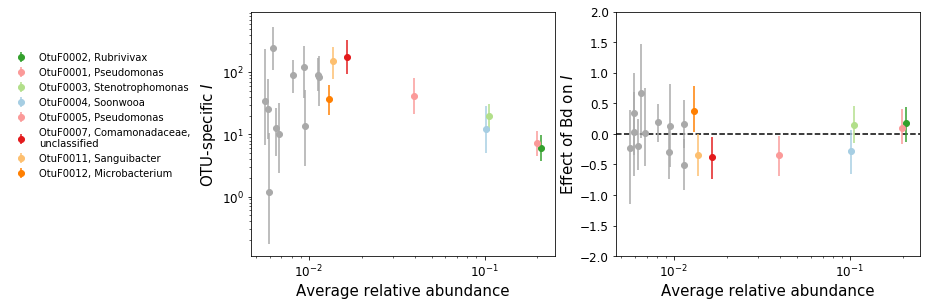

In [40]:
num_otus = 19
colors = ['#33a02c', '#fb9a99','#b2df8a','#a6cee3','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']
models = ["mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=False, sharey=False)


axes = axes.ravel()
labelsize = 15

for model in  models:
    
    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))

    Ω = stats.scoreatpercentile(stanfit['Omega'], 50, axis=0)
    β = stats.scoreatpercentile(stanfit['Beta'], 50, axis=0)

    logbd = np.log10(bd_load + 1)
    pred_bd = np.linspace(0, np.max(logbd), num=30)
    pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)
    bd_val = (0 - np.mean(logbd)) / np.std(logbd)

    X = dmatrix("svl + x - 1", data={"x": pred_bd_z, "svl": np.repeat(0, len(pred_bd_z))})
    # Add six columns of zeros to account for lakes
    Xzeros = np.zeros(len(X)*6).reshape(len(X), 6)
    X = np.hstack([np.ones(len(X))[:, np.newaxis], Xzeros, X])
    Z = dmatrix("x", data={"x": pred_bd_z})

    Is = np.exp(np.dot(X, β) + np.dot(Z, Ω))
    
#     for col in range(8):
        
#         lab = metacomm_p.index[col] + ", " + otu_tax.loc[metacomm_p.index[col]]['Genus']
#         print(lab)
#         if lab == "Otu0007, unclassified":
#             lab = "Otu0007, Comamonadaceae,\nunclassified"
            
#         axes[0].plot(pred_bd, Is[:, col], lw=3, color=colors[col], label=lab)
    
#     for col in range(8, 19):
#         axes[0].plot(pred_bd, Is[:, col], color="gray", lw=1, zorder=-1)
    
    
#     axes[0].set_yscale("log")
#     axes[0].set_ylabel("Fundamental recruitment #, I", size=labelsize)
#     axes[0].set_xlabel("log10(Bd load + 1)", size=labelsize)
#     axes[0].legend(loc=(-1.2, 0.3), frameon=False, prop={'size': 10})
    
    tslopes_full = []
    tints_full = []

    # Need to do this via simulation
    rs = np.random.choice(np.arange(stanfit['Beta'].shape[0]), size=500)
    for r in rs:
        
        tΩ = stanfit['Omega'][r, :, :]
        tβ = stanfit['Beta'][r, :, :]
        
        tslopes_full.append((tβ[[0, 8], :] + tΩ)[1, :]) # Bd effect 
        tints_full.append(np.exp(np.dot(X, tβ) + np.dot(Z, tΩ))[0, :]) # Take the prediction of I when Bd is absent
        
    tslopes = stats.scoreatpercentile(np.array(tslopes_full), (2.5, 50, 97.5), axis=0)
    tints = stats.scoreatpercentile(np.array(tints_full), (2.5, 50, 97.5), axis=0)
    
    num = 19
    # Calculate correlation coefficients
    r1, p1, lo1, hi1 = pearsonr_ci(np.log10(metacomm_p[:num]), tslopes[1, :])
    r2, p2, lo2, hi2 = pearsonr_ci(np.log10(metacomm_p[:num]), tints[1, :])
    
#     axes[0].text(0.5, 0.95, "r = {0:.2f}, [{1:.2f}, {2:.2f}]".format(r1, lo1, hi1), 
#                  ha='center', transform=axes[0].transAxes)
#     axes[1].text(0.5, 0.95, "r = {0:.2f}, [{1:.2f}, {2:.2f}]".format(r2, lo2, hi2), 
#                ha='center', transform=axes[1].transAxes)
    
    for i in range(8):
        
        lab = metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus']
        lab = lab.replace("Otu", "OtuF")
        if lab == "OtuF0007, unclassified":
            lab = "OtuF0007, Comamonadaceae,\nunclassified"
            
        axes[1].errorbar([metacomm_p[i]], 
                         [tslopes[1, i]], yerr=[[tslopes[1, i] - tslopes[0, i]], 
                                                [tslopes[2, i] - tslopes[1, i]]], 
                                         marker="o", linestyle="", color=colors[i], label=lab)
        axes[0].errorbar([metacomm_p[i]], 
                         [tints[1, i]], yerr=[[tints[1, i] - tints[0, i]], 
                                              [tints[2, i] - tints[1, i]]], 
                                         marker="o", linestyle="", color=colors[i])
    for i in range(8, 19):
        axes[1].errorbar([metacomm_p[i]], 
                         [tslopes[1, i]], yerr=[[tslopes[1, i] - tslopes[0, i]], 
                                                [tslopes[2, i] - tslopes[1, i]]], 
                                         marker="o", linestyle="", color="#A9A9A9")
        axes[0].errorbar([metacomm_p[i]], 
                         [tints[1, i]], yerr=[[tints[1, i] - tints[0, i]], 
                                              [tints[2, i] - tints[1, i]]], 
                                         marker="o", linestyle="", color="#A9A9A9")
    
    axes[1].legend(loc=(-2, 0.3), frameon=False, prop={'size': 10})
    axes[1].set_xscale("log")
    axes[1].set_xlabel("Average relative abundance", size=labelsize)
    axes[1].set_ylabel("Effect of Bd on $I$", size=labelsize)
    xlim = axes[1].get_xlim()
    axes[1].hlines(0, *xlim, zorder=-5, linestyle="dashed")
    axes[1].set_xlim(xlim)
    
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")

    #axes[2].plot(np.log(metacomm_p[:num]), tints[1][:num], 'o')
    axes[0].set_xlabel("Average relative abundance", size=labelsize)
    axes[0].set_ylabel("OTU-specific $I$", size=labelsize)
    
    axes[0].set_ylim(0.11, 950)
    axes[1].set_ylim(-2, 2)
    #axes[2].set_ylim(0.3, 500)
    
    for ax in axes:
        ax.tick_params(labelsize=12)
#plt.tight_layout()
fig.savefig("../results/dispersal_otu_specific_field.pdf", bbox_inches="tight")

In [26]:
dmatrix("scale(SVL) + logZE_z + C(Lake_ID)", data=site_dat, return_type="dataframe").columns

Index(['Intercept', 'C(Lake_ID)[T.11525]', 'C(Lake_ID)[T.50183]',
       'C(Lake_ID)[T.72425]', 'C(Lake_ID)[T.72808]', 'C(Lake_ID)[T.72974]',
       'C(Lake_ID)[T.72996]', 'scale(SVL)', 'logZE_z'],
      dtype='object')

**Selection effects**

Looking at Bd-specific effects on the mean. In other words, selection effects.

In [30]:
num_otus = 19
samp_size = sorted_otus.shape[0]
Nts = sorted_otus.sum(axis=1).values
abund_otus = sorted_otus.iloc[:, :num_otus]
other_otus = sorted_otus.iloc[:, num_otus:].sum(axis=1)
abund_otus = abund_otus.assign(Other=other_otus)
abund = abund_otus.values
relative_otus = (abund_otus.values.T / abund_otus.sum(axis=1).values).T

In [146]:
dmatrix("C(Lake_ID)*logZE_z + C(Lake_ID)*np.power(logZE_z, 2)", data=site_dat, return_type="dataframe").columns

Index(['Intercept', 'C(Lake_ID)[T.72425]', 'C(Lake_ID)[T.72808]',
       'C(Lake_ID)[T.72974]', 'C(Lake_ID)[T.72996]', 'logZE_z',
       'C(Lake_ID)[T.72425]:logZE_z', 'C(Lake_ID)[T.72808]:logZE_z',
       'C(Lake_ID)[T.72974]:logZE_z', 'C(Lake_ID)[T.72996]:logZE_z',
       'np.power(logZE_z, 2)', 'C(Lake_ID)[T.72425]:np.power(logZE_z, 2)',
       'C(Lake_ID)[T.72808]:np.power(logZE_z, 2)',
       'C(Lake_ID)[T.72974]:np.power(logZE_z, 2)',
       'C(Lake_ID)[T.72996]:np.power(logZE_z, 2)'],
      dtype='object')

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


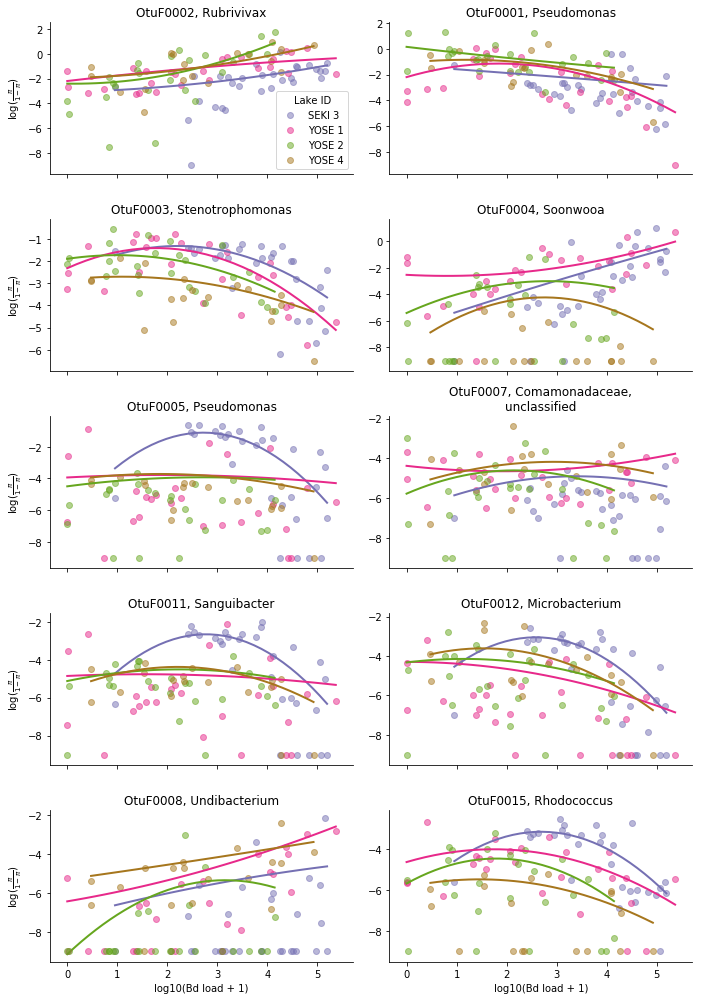

In [38]:
num_otus = 19
colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]
models = ["mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"] #
fig, axes = plt.subplots(5, 2, figsize=(10, 14), sharex=True, sharey=False)
axes = axes.ravel()
num_lakes = len(lake_ids)

for model in  models:

    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))

    for inum, i in enumerate(range(10)): #[0, 1, 2, 3, 5, 7, 9, 11]

        for l, lake in enumerate(np.sort(lake_ids)):
            
            ind = (site_dat.Lake_ID == lake).values
            
            logbd = np.log10(bd_load + 1)
            pred_bd = np.linspace(np.min(logbd[ind]), np.max(logbd[ind]), num=30)
            pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)

            if l != 0:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, l, num_lakes, num_lakes + l, num_lakes*2, num_lakes*2 + l], :]
                X = dmatrix("ones + x + x1 + np.power(x, 2) + np.power(x1, 2)", data={"x": pred_bd_z, "x1": pred_bd_z, "ones": np.repeat(1, len(pred_bd_z))})
                meta_p_logit = np.dot(X, Beta_meta)
            else:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, num_lakes, num_lakes*2], :]
                X = dmatrix("x + np.power(x, 2)", data={"x": pred_bd_z})
                meta_p_logit = np.dot(X, Beta_meta)
            
            if l in [2, 3, 4, 6]:
                
                ax = axes[inum]
                lab = metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus']
                lab = lab.replace("Otu", "OtuF")
                
                if lab == "OtuF0007, unclassified":
                    lab = "OtuF0007, Comamonadaceae,\nunclassified"
                    
                ax.plot(pred_bd, meta_p_logit[:, i], lw=2, color=colors[l])#np.exp(meta_p_logit[:, i]) / (1 + np.exp(meta_p_logit[:, i])), lw=5)
                ax.set_title(lab)

                ind = site_dat.Lake_ID == lake
                logpred = np.log(relative_otus[ind, i]  / (1 - relative_otus[ind, i]))
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=-1, label=maplake[lake], alpha=0.5, color=colors[l])

                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                               marker='o', zorder=5, color=colors[l], alpha=0.5)

        if ax.is_last_row():
            ax.set_xlabel("log10(Bd load + 1)")
        
        if ax.is_first_col():
            ax.set_ylabel(r"$\log(\frac{\pi}{1 - \pi})$")
        
        if inum == 0:
            ax.legend(loc="lower right", title="Lake ID", frameon=True)
        
        ax.spines['right'].set_visible(None)
        ax.spines['top'].set_visible(None)

plt.tight_layout()
fig.savefig("../results/selection_effects_field.pdf", bbox_inches="tight")

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


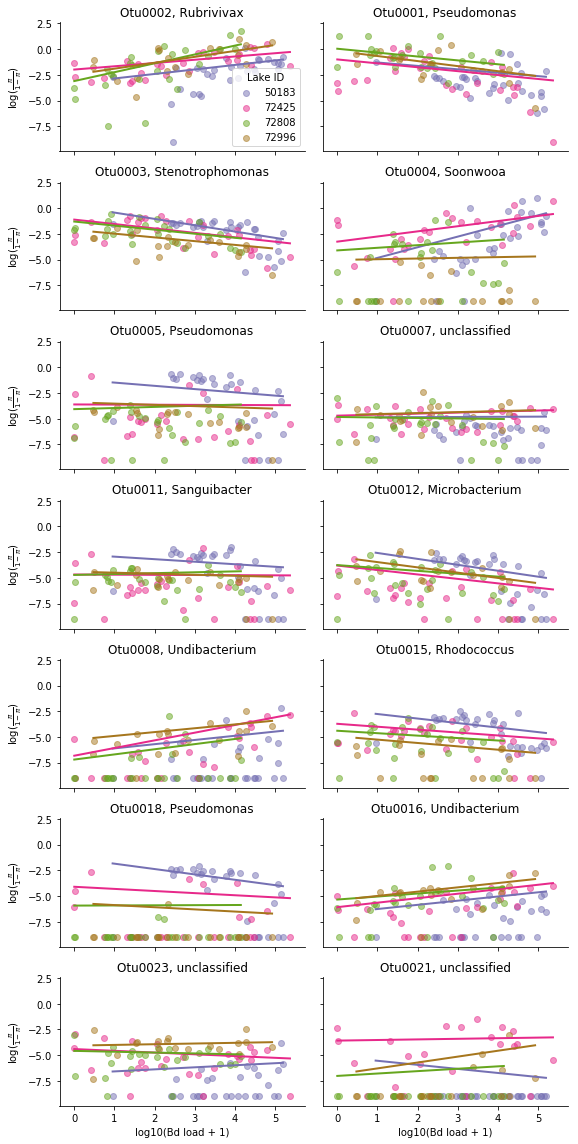

In [39]:
num_otus = 19
colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]
models = ["mean-lake-Bd-int_I-svl-Bd-lake_random-Bd"] #
fig, axes = plt.subplots(7, 2, figsize=(8, 16), sharex=True, sharey=True)
axes = axes.ravel()
num_lakes = len(lake_ids)

for model in  models:

    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))

    for inum, i in enumerate(range(14)): #[0, 1, 2, 3, 5, 7, 9, 11]

        for l, lake in enumerate(np.sort(lake_ids)):
            
            ind = (site_dat.Lake_ID == lake).values
            
            logbd = np.log10(bd_load + 1)
            pred_bd = np.linspace(np.min(logbd[ind]), np.max(logbd[ind]), num=30)
            pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)

            if l != 0:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, l, num_lakes, num_lakes + l], :]
                X = dmatrix("ones + x + x1", data={"x": pred_bd_z, "x1": pred_bd_z, "ones": np.repeat(1, len(pred_bd_z))})
                meta_p_logit = np.dot(X, Beta_meta)
            else:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, num_lakes], :]
                X = dmatrix("x", data={"x": pred_bd_z})
                meta_p_logit = np.dot(X, Beta_meta)
            
            if l in [2, 3, 4, 6]:
                ax = axes[inum]
                ax.plot(pred_bd, meta_p_logit[:, i], lw=2, color=colors[l])#np.exp(meta_p_logit[:, i]) / (1 + np.exp(meta_p_logit[:, i])), lw=5)
                ax.set_title(metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus'])

                ind = site_dat.Lake_ID == lake
                logpred = np.log(relative_otus[ind, i]  / (1 - relative_otus[ind, i]))
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=-1, label=lake, alpha=0.5, color=colors[l])

                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                               marker='o', zorder=5, color=colors[l], alpha=0.5)

        if ax.is_last_row():
            ax.set_xlabel("log10(Bd load + 1)")
        
        if ax.is_first_col():
            ax.set_ylabel(r"$\log(\frac{\pi}{1 - \pi})$")
        
        if inum == 0:
            ax.legend(loc="lower right", title="Lake ID", frameon=True)
        
        ax.spines['right'].set_visible(None)
        ax.spines['top'].set_visible(None)

plt.tight_layout()
#fig.savefig("../results/selection_effects_field.pdf", bbox_inches="tight")

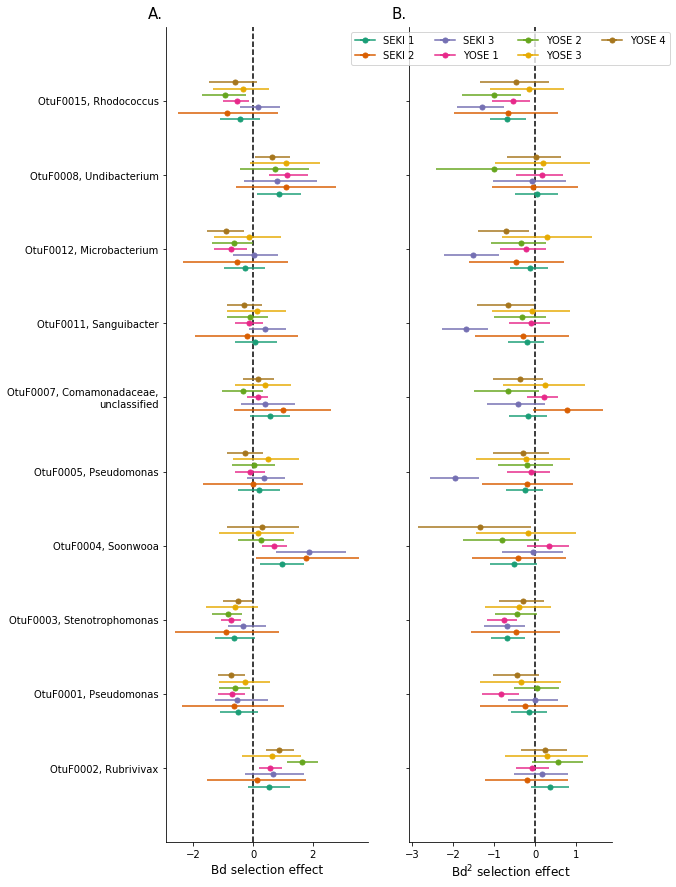

In [39]:
# Plot effect sizes for the top 10 OTUs
fig, axes = plt.subplots(1, 2, figsize=(8, 15), sharey=True)
axes = axes.ravel()
model = "mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"
stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))

#lake_ids = [72996, 50183, 72425, 72808, 72974]
lake_ids = [72996, 50183, 72425, 72808, 72974, 11525, 11516]
num_lakes = len(lake_ids)
adjust = np.linspace(-0.5, 0.5, num=num_lakes)
otu_names = []

include_otus = 10
for otu_num in range(include_otus):
    
    otu_names.append(metacomm_p.index[otu_num] + ", " + otu_tax.loc[metacomm_p.index[otu_num]]['Genus'])
    
    for l, lake in enumerate(np.sort(lake_ids)):
        

        if l != 0:
            l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes, num_lakes + l], otu_num].sum(axis=1), (2.5, 50, 97.5))
            l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes*2, num_lakes*2 + l], otu_num].sum(axis=1), (2.5, 50, 97.5))
        else:
            l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes], otu_num], (2.5, 50, 97.5))
            l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes*2], otu_num], (2.5, 50, 97.5))
        
        if otu_num != 0:
            axes[0].errorbar([m1], [otu_num*2 + adjust[l]], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color=colors[l])
            axes[1].errorbar([m2], [otu_num*2 + adjust[l]], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color=colors[l])
        else:
            axes[0].errorbar([m1], [otu_num*2 + adjust[l]], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color=colors[l])
            axes[1].errorbar([m2], [otu_num*2 + adjust[l]], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color=colors[l],  label=maplake[lake])

for ax in axes:
    ax.vlines(0, -2, include_otus*2, zorder=-2, linestyle='--')
    ax.set_yticks(np.arange(include_otus*2, step=2))
    
    if ax.is_first_col():
        totus = np.array(otu_names).astype('<U50')
        totus[totus == "Otu0007, unclassified"] = "Otu0007, Comamonadaceae,\nunclassified"
        totus = [totu.replace("Otu", "OtuF") for totu in totus]
        ax.set_yticklabels(totus, rotation=0)
        #ax.yaxis.set_tick_params(horizontalalignment="center")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
axes[0].set_ylim(-2, include_otus*2)
axes[0].set_xlabel("Bd selection effect", size=12)
axes[1].set_xlabel("Bd$^2$ selection effect", size=12)
axes[1].legend(loc="upper center", ncol=4, frameon=True)
axes[1].text(-0.05, 1.01, "B.", size=15, ha="center", transform=axes[1].transAxes)
axes[0].text(-0.05, 1.01, "A.", size=15, ha="center", transform=axes[0].transAxes)

fig.savefig("../results/selection_effects_field_cis.pdf", bbox_inches="tight")

In [75]:
totus

array(['Otu0002, Rubrivivax', 'Otu0001, Pseudomonas',
       'Otu0003, Stenotrophomonas', 'Otu0004, Soonwooa',
       'Otu0005, Pseudomonas', 'Otu0007, Comamonadaceae, ',
       'Otu0011, Sanguibacter', 'Otu0012, Microbacterium',
       'Otu0008, Undibacterium', 'Otu0015, Rhodococcus'], dtype='<U25')

In [69]:
otu_names

['Otu0002, Rubrivivax',
 'Otu0001, Pseudomonas',
 'Otu0003, Stenotrophomonas',
 'Otu0004, Soonwooa',
 'Otu0005, Pseudomonas',
 'Otu0007, unclassified',
 'Otu0011, Sanguibacter',
 'Otu0012, Microbacterium',
 'Otu0008, Undibacterium',
 'Otu0015, Rhodococcus']

0.14556152850706455

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


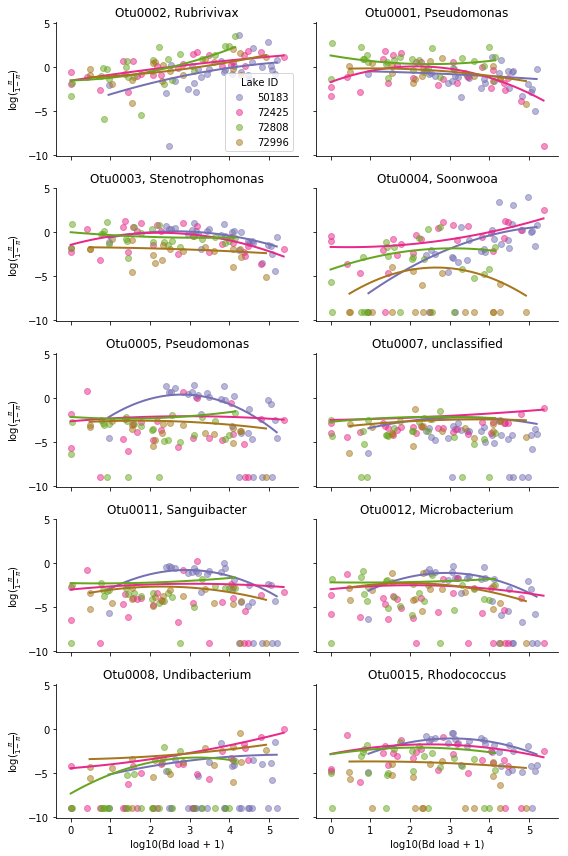

In [42]:
num_otus = 19
colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]
models = ['mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet'] #
fig, axes = plt.subplots(5, 2, figsize=(8, 12), sharex=True, sharey=True)
axes = axes.ravel()
num_lakes = len(lake_ids)

for model in  models:

    stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))
    
    for inum, i in enumerate(range(10)):

        for l, lake in enumerate(np.sort(lake_ids)):
            
            ind = (site_dat.Lake_ID == lake).values
            
            logbd = np.log10(bd_load + 1)
            pred_bd = np.linspace(np.min(logbd[ind]), np.max(logbd[ind]), num=30)
            pred_bd_z = (pred_bd - np.mean(logbd)) / np.std(logbd)

            if l != 0:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, l, num_lakes, num_lakes + l, num_lakes*2, num_lakes*2 + l], :]
                X = dmatrix("ones + x + x1 + np.power(x, 2) + np.power(x1, 2)", data={"x": pred_bd_z, "x1": pred_bd_z, "ones": np.repeat(1, len(pred_bd_z))})
                meta_p_logit = np.dot(X, Beta_meta)
            else:
                Beta_meta = stanfit['Beta_meta'].mean(axis=0)[[0, num_lakes, num_lakes*2], :]
                X = dmatrix("x + np.power(x, 2)", data={"x": pred_bd_z})
                meta_p_logit = np.dot(X, Beta_meta)
            
            if l in [2, 3, 4, 6]:
                ax = axes[inum]
                ax.plot(pred_bd, meta_p_logit[:, i], lw=2, color=colors[l])#np.exp(meta_p_logit[:, i]) / (1 + np.exp(meta_p_logit[:, i])), lw=5)
                ax.set_title(metacomm_p.index[i] + ", " + otu_tax.loc[metacomm_p.index[i]]['Genus'])

                logpred = np.log(relative_otus[ind, i]  / (relative_otus[ind, 19]))
                ax.scatter(logbd[ind], logpred, 
                           marker='o', zorder=-1, label=lake, alpha=0.5, color=colors[l])

                zeros = logpred == -np.inf
                ax.scatter(logbd[ind][zeros], np.repeat(-9, np.sum(zeros)), 
                               marker='o', zorder=5, color=colors[l], alpha=0.5)

        if ax.is_last_row():
            ax.set_xlabel("log10(Bd load + 1)")
        
        if ax.is_first_col():
            ax.set_ylabel(r"$\log(\frac{\pi}{1 - \pi})$")
        
        if inum == 0:
            ax.legend(loc="lower right", title="Lake ID", frameon=True)
        
        ax.spines['right'].set_visible(None)
        ax.spines['top'].set_visible(None)

plt.tight_layout()

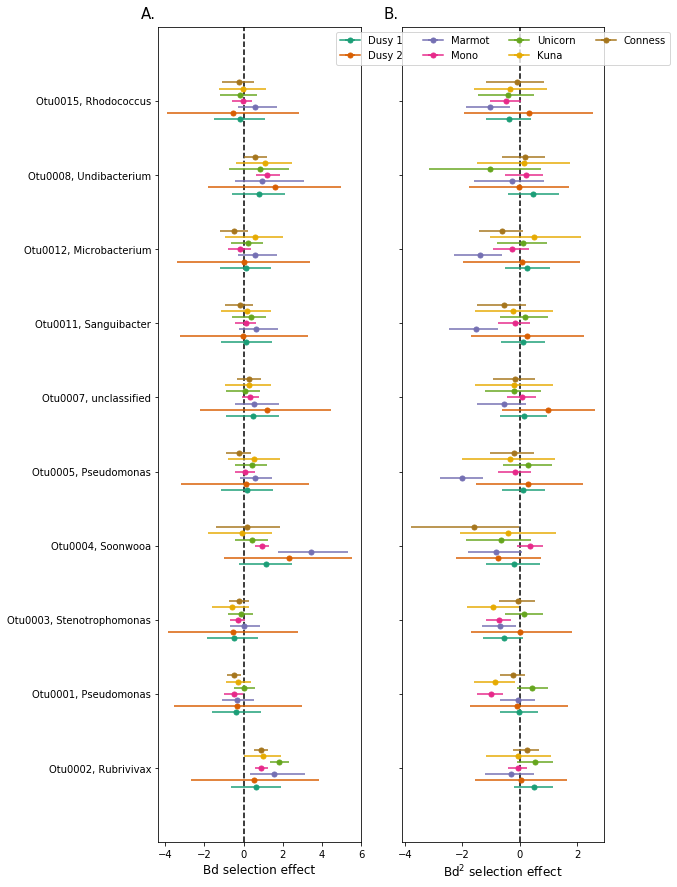

In [45]:
# Plot effect sizes for the top 10 OTUs
fig, axes = plt.subplots(1, 2, figsize=(8, 15), sharey=True)
axes = axes.ravel()
model = 'mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet'
stanfit, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))

num_lakes = len(lake_ids)
adjust = np.linspace(-0.5, 0.5, num=num_lakes)
otu_names = []

include_otus = 10
for otu_num in range(include_otus):
    
    otu_names.append(metacomm_p.index[otu_num] + ", " + otu_tax.loc[metacomm_p.index[otu_num]]['Genus'])
    
    for l, lake in enumerate(np.sort(lake_ids)):
        

        if l != 0:
            l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes, num_lakes + l], otu_num].sum(axis=1), (2.5, 50, 97.5))
            l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes*2, num_lakes*2 + l], otu_num].sum(axis=1), (2.5, 50, 97.5))
        else:
            l1, m1, u1 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes], otu_num], (2.5, 50, 97.5))
            l2, m2, u2 = stats.scoreatpercentile(stanfit['Beta_meta'][:, [num_lakes*2], otu_num], (2.5, 50, 97.5))
        
        if otu_num != 0:
            axes[0].errorbar([m1], [otu_num*2 + adjust[l]], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color=colors[l])
            axes[1].errorbar([m2], [otu_num*2 + adjust[l]], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color=colors[l])
        else:
            axes[0].errorbar([m1], [otu_num*2 + adjust[l]], xerr=[[m1 - l1], [u1 - m1]], marker='o', markersize=5, color=colors[l])
            axes[1].errorbar([m2], [otu_num*2 + adjust[l]], xerr=[[m2 - l2], [u2 - m2]], marker='o', markersize=5, color=colors[l],  label=maplake[lake])


for ax in axes:
    ax.vlines(0, -2, include_otus*2, zorder=-2, linestyle='--')
    ax.set_yticks(np.arange(include_otus*2, step=2))
    
    if ax.is_first_col():
        ax.set_yticklabels(otu_names, rotation=0)
        
axes[0].set_ylim(-2, include_otus*2)
axes[0].set_xlabel("Bd selection effect", size=12)
axes[1].set_xlabel("Bd$^2$ selection effect", size=12)
axes[1].legend(loc="upper center", ncol=4, frameon=True)
axes[1].text(-0.05, 1.01, "B.", size=15, ha="center", transform=axes[1].transAxes)
axes[0].text(-0.05, 1.01, "A.", size=15, ha="center", transform=axes[0].transAxes)

fig.savefig("../results/selection_effects_field_cis_dirichlet.pdf", bbox_inches="tight")

# Compare multivariate model and independent species model

In [89]:
nms = dmatrix("scale(SVL) + logZE_z + C(Lake_ID)", data=site_dat, return_type="dataframe").columns

In [94]:
model = "mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"
stanfit_ind, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))
dt_ind = pd.DataFrame(stats.scoreatpercentile(stanfit_ind['beta'], (2.5, 50, 97.5), axis=0), columns=nms)

In [95]:
model = "mean-lake-Bd2-int_I-svl-Bd-lake_dirichlet"
stanfit_mult, standata, X, Z, W, bd_load = pd.read_pickle("../results/model_fits/{0}-numOTU{1}.pkl".format(model, num_otus))
dt_mult = pd.DataFrame(stats.scoreatpercentile(stanfit_mult['beta'], (2.5, 50, 97.5), axis=0), columns=nms)

scale(SVL)
logZE_z


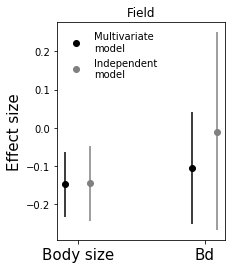

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

columns = dt_mult.columns
for i, col in enumerate(columns[-2:]):
    print(col)
    med_mult = dt_mult[col].iloc[1]
    med_ind = dt_ind[col].iloc[1]
    low_mult = med_mult - dt_mult[col].iloc[0]
    high_mult = dt_mult[col].iloc[2] - med_mult
    low_ind = med_ind - dt_ind[col].iloc[0]
    high_ind = dt_ind[col].iloc[2] - med_ind
    
    
    ax.errorbar([i - 0.1], [dt_mult[col].iloc[1]], yerr=[[low_mult], [high_mult]], marker='o', color="black")
    ax.errorbar([i + 0.1], [dt_ind[col].iloc[1]], yerr=[[low_ind], [high_ind]], marker='o', color="gray")

ax.legend([plt.Line2D([0], [0], marker='o', linestyle="", color=c) for c in ["black", "gray"]],
          ("Multivariate\nmodel", "Independent\nmodel"), loc="upper left", frameon=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Body size", "Bd"], size=15)
ax.set_ylabel("Effect size", size=15)
ax.set_title("Field")
plt.savefig("../results/multivariate_vs_independent_field.pdf", bbox_inches="tight")